When we talk about quantum computing, we actually talk about several different paradigms. The most common one is gate-model quantum computing, in the vein we discussed in the previous notebook. In this case, gates are applied on qubit registers to perform arbitrary transformations of quantum states made up of qubits.

The second most common paradigm is quantum annealing. This paradigm is often also referred to as adiabatic quantum computing, although there are subtle differences. Quantum annealing solves a more specific problem -- universality is not a requirement -- which makes it an easier, albeit still difficult engineering challenge to scale it up. The technology is up to 2000 superconducting qubits in 2018, compared to the less than 100 qubits on gate-model quantum computers. D-Wave Systems has been building superconducting quantum annealers for over a decade and this company holds the record for the number of qubits -- 2048. More recently, an IARPA project was launched to build novel superconducting quantum annealers. A quantum optics implementation was also made available by QNNcloud that implements a coherent Ising model. Its restrictions are different from superconducting architectures.

Gate-model quantum computing is conceptually easier to understand: it is the generalization of digital computing. Instead of deterministic logical operations of bit strings, we have deterministic transformations of (quantum) probability distributions over bit strings. Quantum annealing requires some understanding of physics, which is why we introduced classical and quantum many-body physics in a previous notebook. Over the last few years, quantum annealing inspired gate-model algorithms that work on current and near-term quantum computers (see the notebook on variational circuits). So in this sense, it is worth developing an understanding of the underlying physics model and how quantum annealing works, even if you are only interested in gate-model quantum computing.

While there is a plethora of quantum computing languages, frameworks, and libraries for the gate-model, quantum annealing is less well-established. D-Wave Systems offers an open source suite called Ocean. A vendor-independent solution is XACC, an extensible compilation framework for hybrid quantum-classical computing architectures, but the only quantum annealer it maps to is that of D-Wave Systems. Since XACC is a much larger initiative that extends beyond annealing, we choose a few much simpler packages from Ocean to illustrate the core concepts of this paradigm. However, before diving into the details of quantum annealing, it is worth taking a slight detour to connect the unitary evolution we discussed in a closed system and in the gate-model paradigm and the Hamiltonian describing a quantum many-body system. We also briefly discuss the adiabatic theorem, which provides the foundation why quantum annealing would work at all.

# Unitary evolution and the Hamiltonian

We introduced the Hamiltonian as an object describing the energy of a classical or quantum system. Something more is true: it gives a description of a system evolving with time. This formalism is expressed by the Schrödinger equation:

$$
\imath\hbar {\frac {d}{dt}}|\psi(t)\rangle = H|\psi(t)\rangle,
$$

where $\hbar$ is the reduced Planck constant. Previously we said that it is a unitary operator that evolves state. That is exactly what we get if we solve the Schrödinger equation for some time $t$: $U = \exp(-\imath Ht/\hbar)$. Note that we used that the Hamiltonian does not depend on time. In other words, every unitary we talked about so far has some underlying Hamiltonian.

The Schrödinger equation in the above form is the time-dependent variant: the state depends on time. The time-independent Schröndinger equation reflects what we said about the Hamiltonian describing the energy of the system:

 $$
 H|\psi \rangle =E|\psi \rangle,
$$

where $E$ is the total energy of the system.

# The adiabatic theorem and adiabatic quantum computing

An adiabatic process means that conditions change slowly enough for the system to adapt to the new configuration. For instance, in a quantum mechanical system, we can start from some Hamiltonian $H_0$ and slowly change it to some other Hamiltonian $H_1$. The simplest change could be a linear schedule:

$$
H(t) = (1-t) H_0 + t H_1,
$$

for $t\in[0,1]$ on some time scale. This Hamiltonian depends on time, so solving the Schrödinger equation is considerably more complicated. The adiabatic theorem says that if the change in the time-dependent Hamiltonian occurs slowly, the resulting dynamics remain simple: starting close to an eigenstate, the system remains close to
an eigenstate. This implies that if the system started in the ground state, if certain conditions are met, the system stays in the ground state. 

We call the energy difference between the ground state and the first excited state the gap. If $H(t)$ has a nonnegative gap for each $t$ during the transition and the change happens slowly, then the system stays in the ground state. If we denote the time-dependent gap by $\Delta(t)$, a course approximation of the speed limit scales as $1/\min(\Delta(t))^2$.

This theorem allows something highly unusual. We can reach the ground state of an easy-to-solve quantum many body system, and change the Hamiltonian to a system we are interested in. For instance, we could start with the Hamiltonian $\sum_i \sigma^X_i$ -- its ground state is just the equal superposition. Let's see this on two sites:

In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

X = np.array([[0, 1], [1, 0]])
IX = np.kron(np.eye(2), X)
XI = np.kron(X, np.eye(2))
H_0 = - (IX + XI)
λ, v = np.linalg.eigh(H_0)
print("Eigenvalues:", λ)
print("Eigenstate for lowest eigenvalue", v[:, 0])

Eigenvalues: [-2. -0.  0.  2.]
Eigenstate for lowest eigenvalue [-0.5 -0.5 -0.5 -0.5]


Then we could turn this Hamiltonian slowly into a classical Ising model and read out the global solution.

<img src="figures/annealing_process.svg" alt="Annealing process" style="width: 400px;"/>


Adiabatic quantum computation exploits this phenomenon and it is able to perform universal calculations with the final Hamiltonian being $H=-\sum_{<i,j>} J_{ij} \sigma^Z_i \sigma^Z_{j} - \sum_i h_i \sigma^Z_i - \sum_{<i,j>} g_{ij} \sigma^X_i\sigma^X_j$. Note that is not the transverse-field Ising model: the last term is an X-X interaction. If a quantum computer respects the speed limit, guarantees the finite gap, and implements this Hamiltonian, then it is equivalent to the gate model with some overhead.

The quadratic scaling on the gap does not appear too bad. So can we solve NP-hard problems faster with this paradigm? It is unlikely. The gap is highly dependent on the problem, and actually difficult problems tend to have an exponentially small gap. So our speed limit would be quadratic over the exponentially small gap, so the overall time required would be exponentially large.

# Quantum annealing

A theoretical obstacle to adiabatic quantum computing is that calculating the speed limit is clearly not trivial; in fact, it is harder than solving the original problem of finding the ground state of some Hamiltonian of interest. Engineering constraints also apply: the qubits decohere, the environment has finite temperature, and so on. *Quantum annealing* drops the strict requirements and instead of respecting speed limits, it repeats the transition (the annealing) over and over again. Having collected a number of samples, we pick the spin configuration with the lowest energy as our solution. There is no guarantee that this is the ground state.

Quantum annealing has a slightly different software stack than gate-model quantum computers. Instead of a quantum circuit, the level of abstraction is the classical Ising model -- the problem we are interested in solving must be in this form. Then, just like superconducting gate-model quantum computers, superconducting quantum annealers also suffer from limited connectivity. In this case, it means that if our problem's connectivity does not match that of the hardware, we have to find a graph minor embedding. This will combine several physical qubits into a logical qubit. The workflow is summarized in the following diagram [[1](#1)]:

<img src="figures/quantum_annealing_workflow.png" alt="Software stack on a quantum annealer" style="width: 400px;"/>

A possible classical solver for the Ising model is the simulated annealer that we have seen before:

In [2]:
import dimod

J = {(0, 1): 1.0, (1, 2): -1.0}
h = {0:0, 1:0, 2:0}
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print("Energy of samples:")
print([solution.energy for solution in response.data()])

Energy of samples:
[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0]


Let's take a look at the minor embedding problem. This part is NP-hard in itself, so we normally use  probabilistic heuristics to find an embedding. For instance, for many generations of the quantum annealer that D-Wave Systems produces has unit cells containing a $K_{4,4}$ bipartite fully-connected graph, with two remote connections from each qubit going to qubits in neighbouring unit cells. A unit cell with its local and remote connections indicated is depicted following figure:

<img src="figures/unit_cell.png" alt="Unit cell in Chimera graph" style="width: 80px;"/>

This is called the Chimera graph. The current largest hardware has 2048 qubits, consisting of $16\times 16$ unit cells of 8 qubits each. The Chimera graph is available as a `networkx` graph in the package `dwave_networkx`. We draw a smaller version, consisting of $2\times 2$ unit cells.

/home/pwittek/.anaconda3/envs/qiskit/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


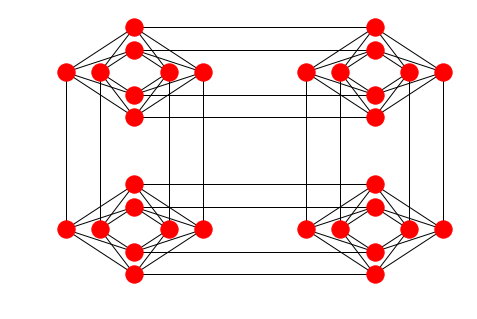

In [3]:
import matplotlib.pyplot as plt
import dwave_networkx as dnx
%matplotlib inline

connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

Let's create a graph that certainly does not fit this connectivity structure. For instance, the complete graph $K_n$ on nine nodes:

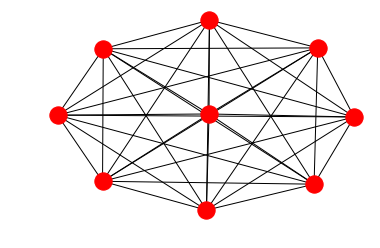

In [4]:
import networkx as nx
G = nx.complete_graph(9)
plt.axis('off') 
nx.draw_networkx(G, with_labels=False)

In [5]:
import minorminer
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())

Let's plot this embedding:

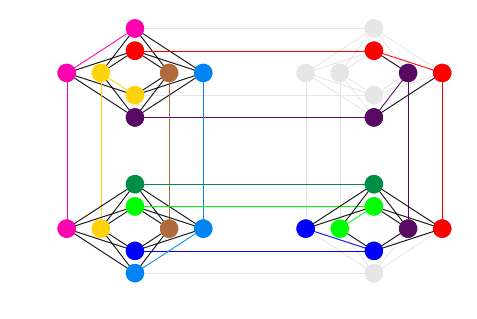

In [6]:
dnx.draw_chimera_embedding(connectivity_structure, embedded_graph)
plt.show()

Qubits that have the same colour corresponding to a logical node in the original problem defined by the $K_9$ graph. Qubits combined in such way form a chain. Even though our problem only has 9 variables (nodes), we used almost all 32 available on the toy Chimera graph. Let's find the maximum chain length:

In [7]:
max_chain_length = 0
for _, chain in embedded_graph.items():
    if len(chain) > max_chain_length:
        max_chain_length = len(chain)
print(max_chain_length)

4


The chain on the hardware is implemented by having strong couplings between the elements in a chain -- in fact, twice as strong as what the user can set. Nevertheless, long chains can break, which means we receive inconsistent results. In general, we prefer shorter chains, so we do not waste physical qubits and we obtain more reliable results.

# References

[1] M. Fingerhuth, T. Babej, P. Wittek. (2018). [Open source software in quantum computing](https://doi.org/10.1371/journal.pone.0208561). *PLOS ONE* 13(12):e0208561.  <a id='1'></a>